#Tên: Trần Đại Chí
#MSSV: 18127070

Chúng ta sẽ chia làm tổng cộng 3 phần cho bài lab này. Ở phần 1, chúng ta sẽ tải toàn bộ dataset về từ cuộc thi dự đoán liên kết trên đồ thị mạng xã hội của Facebook tại link sau https://www.kaggle.com/c/FacebookRecruiting/overview. Ở phần 2, chúng ta sẽ đề cập đến cách thức mà tác giả huấn luyện mô hình như cách tạo ra các tập dữ liệu train, test, các liên kết giả hay còn gọi là kỹ thuật lấy mẫu âm (negative sampling), cách tính các độ đo tương tự và 1 số đặc trưng khác như tính đường dẫn ngắn nhất, kiểm tra 2 nút thuộc cùng 1 cộng đồng hay không... để cải thiện kết quả dự đoán cho mô hình. Ở phần cuối cùng, chúng ta sẽ chạy thực nghiệm và giải thích lại từng phần trong code của tác giả trên tập dữ liệu đã được cung cấp sẵn

# 1. Tải dữ liệu từ kaggle
Khi tải dữ liệu ở kaggle từ 1 cuộc thi nào đó về, nó đòi hỏi chúng ta cần phải xuất file json tài khoản kaggle của chúng ta và upload lên colab, sau đó chúng ta sẽ chạy tiếp các đoạn code như dưới đây là có thể tải thành công toàn bộ dữ liệu từ cuộc thi đó về

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c FacebookRecruiting

#2. Các quy trình huấn luyện mô hình cho bài toán dự đoán liên kết, các độ đo tương tự, các độ đo xếp hạng, các độ đo đánh giá và 1 số đặc trưng khác
2.1 Về phần quy trình huấn luyện mô hình cho bài toán dự đoán liên kết, ở cuộc thi này, tác giả sẽ coi vấn đề dự đoán liên kết trên đồ thị mạng xã hội như là 1 vấn đề phân loại. Chúng ta có thể hiểu đơn giản vấn đề phân loại ở đây là với các liên kết mà tồn tại thật thì sẽ có nhãn là 1 và với các liên kết giả được tạo ra thì sẽ có nhãn là 0. Về toàn bộ các bước của tác giả sẽ được mô tả chi tiết như sau
+ Đầu tiên, tác giả tiến hành bước tiền xử lý bằng cách đọc file train.csv (file này bao gồm 2 cột ở dạng int, 1 cột là các nút nguồn và cột còn lại là các nút đích mà chỉ ra 1 người đang follow 1 người trên mạng xã hội) và kiểm tra có dữ liệu NaN hay hàng nào bị trùng không, sau khi kiểm tra không có vấn đề gì bất thường thì sẽ đọc toàn bộ file dữ liệu này bằng networkx ở dạng đồ thị có hướng
+ Sau khi đã có được đồ thị có hướng, tác giả tiến hành tạo các liên kết giả hay còn gọi là lấy mẫu âm (negative sampling) bằng cách gán toàn bộ các liên kết trong mạng ban đầu là 1, sau đó tạo ra 2 biến ngẫu nhiên a và b mà nhận 
các giá trị từ 1 đến 1.862.220 vì mạng ban đầu có nút lớn nhất là 1.862.220. Khi đã có 2 biến a và b khác nhau thì nếu chiều dài đường dẫn ngắn nhất giữa 2 biến này > 2 thì tác giả coi đó là 1 liên kết giả và gán nó là -1 để phân biệt với các liên kết thật
+ Sau khi đã có được 2 file csv bao gồm các liên kết thật và các liên kết giả, tác giả tiến hành chia train, test cho 2 file này với tỷ lệ là 80:20 và đọc chỉ tập train ở cả 2 file này vào 2 đồ thị để kiểm tra 1 số thông tin như số người có ở trong cả 2 tập train và test, số người ko có trong tập train nhưng lại có trong tập test và phát hiện có vấn đề coldstart xảy ở ra đây nên để giải quyết vấn đề này, tác giả đọc cả phần train, test ở cả 2 file lên và gộp phần train ở file 1 bao gồm các liên kết thật vào phần train ở file 2 bao gồm các liên kết giả lại với nhau. Một cách tương tự thì phần test ở cả 2 file cũng được gộp như vậy
+ Ở bước tiếp theo, tác giả tiến hành đọc 2 file train và test sau khi đã gộp xong ở trên nhưng để tránh bị vượt quá bộ nhớ khi đọc 1 file lớn vào dataframe, tác giả chỉ đọc 1 lượng nhỏ các hàng trong file ở vị trí ngẫu nhiên và bỏ qua 
các hàng còn lại
+ Sau khi đã đọc và có được 2 dataframe từ bước trên, tác giả tiến hành thêm vào 1 số đặc trưng để mô hình dự đoán như độ đo jaccard, cosine, tổng số người mà 1 người đang theo dõi và được theo dõi và tổng số người đang theo dõi và 
được theo dõi mà có chung ở cả nút nguồn lẫn nút đích của liên kết tương ứng, chỉ số adar, đánh nhãn cho biết 2 nút nguồn và đích có thuộc về cùng 1 cộng đồng kết nối hay không, nút đích có theo dõi nút nguồn hay không, đường dẫn ngắn nhất giữa nút nguồn và nút đích mà không tính đường dẫn trực tiếp (nếu có), trọng số các cạnh vào, ra, page rank của các nút nguồn và nút đích, katz của các nút nguồn và nút đích, hits của các nút nguồn và nút đích, các đặc trưng SVD cho các nút nguồn và nút đích
+ Cuối cùng, sau khi dataframe đã có đủ các cột đặc trưng đủ để cho mô hình dự đoán, tác giả loại bỏ 3 cột nút nguồn, nút đích và cột nhãn dự đoán của liên kết và sử dụng mô hình RandomForestClassifier để dự đoán và đánh giá mô hình theo độ đo f1 score thì kết quả tốt nhất đạt được trên tập train và test tương ứng là 0.966 và 0.927 tại chiều sâu của mô hình là 20. Để xem với các siêu tham số khác mô hình còn đạt được kết quả tốt hơn không, tác giả sử dụng RandomizedSearchCV() để dò ra các siêu tham số tốt nhất cho mô hình và kết quả cuối cùng tính theo độ đo f1 score cho cả tập train và test vẫn giữ như cũ nên có thể thấy đây là kết quả tốt nhất hiện tại mà mô hình đạt được
+ Ở bước trên thì tác giả huấn luyện mô hình trên tập train và test mà bao gồm các liên kết thật và các liên kết giả, ở bước này tác giả tiến hành đọc train và test mà chỉ bao gồm các liên kết thật vào 2 đồ thị mới. Tiếp theo, tác giả
sẽ tính lại tổng số người theo dõi cho các nút nguồn và nút đích ở trong 2 đồ thị mới này và đưa các cột mới này vào 2 dataframe train và test mà đã tạo ra ở trên và tác giả thêm 1 số đặc trưng mới vào dataframe train và test này tiếp 
như cột "followers_preferential_attach" và "followers_preferential_attach" mà bao gồm kết quả tổng số lượng theo dõi và được theo dõi ở nút nguồn nhân với tổng số lượng theo dõi và được theo dõi ở nút đích, tích của các thành phần u, s và v ở trong SVD
+ Sau khi đã thêm được 1 số đặc trưng mới vào dataframe như trên, tác giả chuyển sang sử dụng mô hình xgboost với RandomizedSearchCV() để dò ra các siêu tham số tốt nhất và kết quả tốt nhất trên tập train và test bằng độ đo f1 score
lần lượt là 0.992 và 0.908. Với kết quả này thì nhìn chung kết quả train đạt được khá tốt so với mô hình RandomForrestClassifier() với các đặc trưng cũ sử dụng ở trên nhưng kết quả test cho ra lại tệ hơn
+ Trên đây là toàn bộ tóm gọn quy trình cách thức huấn luyện mô hình của tác giả, về phần cải tiến mô hình thì chúng ta có thể
sử dụng 1 phương pháp hiệu quả hơn là stack model mà xếp chồng nhiều mô hình hồi quy lại với nhau và điều chỉnh trọng số phù hợp cho từng mô hình nhưng chúng ta sẽ không đề cập đến cách giải quyết này ở đây

2.2 Về độ đo tương tự, tác giả sử dụng 2 độ đo là chỉ số jaccard và hệ số Otsuka–Ochiai

\begin{equation}
JaccardIndex = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

Về chỉ số jaccard, nó là 1 hệ số thống kê được sử dụng để đánh giá mức độ tương đồng cho 2 nút X và Y, nó được tính bởi công thức như trên (trong đó X và Y là danh sách các nút vào hoặc ra tương ứng của nút đó tùy vào việc chúng ta đang tính chỉ số jaccard cho 2 nút đang theo dõi người khác hay là được người khác theo dõi) và có giá trị từ 0-100%. Nếu giá trị này càng lớn thì 2 nút sẽ càng có nhiều điểm giống nhau. Tuy nhiên, độ đo này có 1 nhược điểm là nó lại nhạy cảm với các bộ dữ liệu có kích thước nhỏ mà dẫn đến kết quả có thể bị sai

\begin{equation}
Otsuka–Ochiai = \frac{|X\cap Y|}{\sqrt{|X|\times|Y|}} 
\end{equation}

Mặc dù trong code tác giả ghi là độ tương tự cosine nhưng về công thức trong code thì nó có phần giống với hệ số Otsuka–Ochiai mà là 1 độ đo tương tự từng được sử dụng trong lĩnh vực sinh học. Về công thức của nó thì được tính như ở trên (trong đó X và Y là là danh sách các nút vào hoặc ra tương ứng của nút đó tùy vào việc chúng ta đang tính độ tương tự cosine cho 2 nút đang theo dõi người khác hay là được người khác theo dõi)

2.3 Về độ đo xếp hạng tác giả sử dụng thuật toán page rank cho các nút nguồn và đích

Page rank là 1 thuật toán kinh điển của google được dùng trong google search để xếp hạng các trang web. Tuy nhiên, khác với khái niệm link popularity mà cho ra kết quả các trang web bằng cách tính độ quan trọng của trang web đó (1 trang web được coi là quan trọng nếu có nhiều trang web liên kết với nó), page rank xác định độ quan trọng của 1 trang web còn dựa trên xếp hạng của các trang web liên kết đến nó. Về cách tính của thuật toán, đầu tiên đưa ra 1 đồ thị có hướng như hình dưới đây

![](https://drive.google.com/uc?export=view&id=1nocJKqKuNFaUFCiz7yAcOdwn6xfp_xwP)

Kết quả page rank của thuật toán này được tính như bảng dưới đây

<table>
  <tr>
    <th></th>
    <th>Iteration 0</th>
    <th>Iteration 1</th>
    <th>Iteration 2</th>
    <th>Page Rank</th>
  </tr>
  <tr>
    <td>A</td>
    <td>1/4</td>
    <td>1/12</td>
    <td>1.5/12</td>
    <td>1</td>
  </tr>
  <tr>
    <td>B</td>
    <td>1/4</td>
    <td>2.5/12</td>
    <td>2/12</td>
    <td>2</td>
  </tr>
  <tr>
    <td>C</td>
    <td>1/4</td>
    <td>4.5/12</td>
    <td>4.5/12</td>
    <td>4</td>
  </tr>
  <tr>
    <td>D</td>
    <td>1/4</td>
    <td>4/12</td>
    <td>4/12</td>
    <td>3</td>
  </tr>
</table>

Đầu tiên, ở iteration 0 chúng ta sẽ tối ưu toàn bộ các trang web có giá trị page rank là 1/N = 1/4 (trong đó N là tổng số trang web). Ở iteration 1, trang web A có trang web C liên kết đến mà page rank của trang web C là 1/4 và có 3 liên kết đi ra nên page rank của trang web A là PR(A) = (1/4)/3 = 1/12. Trang web B có 2 trang web liên kết đến là trang web A và C, trang web A có page rank là 1/4 và có 2 liên kết đi ra, trang web C có page rank là 1/4 và có 3 liên kết đi ra nên page rank của trang web B là PR(B) = (1/4)/2 + (1/4)/3 = 2.5/12. Một cách tương tự, ta sẽ có page rank của trang web C và D ở iteration 1 là 4.5/12 và 4/12. Ở iteration 1, chúng ta cũng sẽ lặp lại các bước như trên nhưng ở mỗi lần tính chúng ta cần lưu ý cập nhật lại giá trị page rank ở iteration trước đó

2.4 Về độ độ đo đánh giá tác giả sử dụng 4 độ đo chính là Precision, Recall, F1 Score và AUC - ROC

Về F1 score, nó là 1 độ đo về sự cân bằng giữa 2 độ đo precision và recall. Nó có công thức F Score = 2*((precision*recall)/(precision+recall)) (trong đó độ chuẩn xác precision sẽ cho chúng ta biết được mô hình của chúng ta phân loại 
các dữ liệu positive tốt ra sao và nó có tông thức là Precision = TP/(TP + FP) với TP là tổng số trường hợp dự đoán mà đúng với mẫu positive và FP là tổng số trường hợp nhãn là negative nhưng được dự đoán thành positive còn với độ phủ recall, nó cho chúng ta biết được tỷ lệ dự báo chính xác với các trường hợp positive trên toàn bộ các mẫu thuộc nhóm positive thực sự là bao nhiêu và nó có công thức là Recall = TP/(TP+FN) với FN là tổng các trường hợp từ positive nhưng dự đoán thành negative). Về AUC - ROC, đây là 1 phương pháp phổ biến được dùng để đánh giá hiệu suất của các mô hình phân lớp bên cạnh 1 phương pháp phổ biến khác là Confusion Matrix. Nếu chỉ số AUC càng cao thì mô hình của chúng ta sẽ càng chính xác hơn trong việc phân lớp. Trong AUC, nó sử dụng 2 chỉ số là TPR và FPR. TPR cho biết tỷ lệ phân loại chính xác giữa các mẫu dương trên toàn bộ các mẫu dương và có công thức giống với Recall. FPR sẽ cho chúng ta biết tỷ lệ các mẫu negative được dự đoán sai thành positive trên toàn bộ các mẫu negative và có công thức là FPR = FP/(TN+FP) với TN là tổng trường hợp dự báo đúng với mẫu negative

2.5 Về 1 số đặc trưng khác mà tác giả thêm vào cho có thêm nhiều dữ liệu để mô hình dự đoán tốt hơn, chúng ta có đặc trưng đường dẫn ngắn nhất mà cho biết đường dẫn ngắn nhất giữa 2 nút trong đồ thị mà đã loại bỏ đường dẫn trực tiếp giữa 2 nút này nếu có tồn tại, kiểm tra 2 nút có thuộc cùng 1 cộng đồng hay không thông qua hàm weakly_connected_components có sẵn trong networkx, kiểm tra xem giữa 2 nút a và b thì nút b có liên kết đến nút a hay không mà cho biết người b có đang follow người a trên mạng xã hội không. Ngoài các đặc trưng này còn có 1 số đặc trưng khác nữa như chỉ số adamic/adar, độ trung tâm katz, điểm hits, đặc trưng trọng số các cạnh vào, ra và các đặc trưng svd mà có sẵn trong thư viện scipy cho các nút nguồn cũng như nút đích

$$Adamic(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

Về chỉ số adamic/adar, nó được định nghĩa là tổng nghịch đảo logarithmic bậc trung tâm của các láng giềng chung của 2 nút với công thức như ở trên mà trong đó N(u) là tập các nút liền kề với u. Nếu giá trị này bằng 0 có nghĩa là 2 nút x và y không liền kề nhau và ngược lại nếu giá trị này càng lớn thì 2 nút sẽ càng gần nhau

$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta$$

Về độ trung tâm katz, nó đo lường mức độ ảnh hưởng của 1 nút trong 1 mạng bằng cánh tính độ trung tâm của nút đó dựa trên độ trung tâm của các nút láng giềng với nó. Độ trugn tâm katz của 1 nút i có công thức như trên mà trong đó A là 1 ma trận kề của đồ thị G với eigenvalues là $\lambda$, $\beta$ là 1 tham số độ trung tâm khởi tạo và $\alpha < \frac{1}{\lambda_{max}}$

Về thuật toán hits thì nó là 1 thuật toán được tạo ra bởi tác giả Jon Kleinberg để phân tích các liên kết để xếp hạng các trang web. Thuật toán này bao gồm 2 bước chính là cập nhật Authority và cập nhật Hub. Authority sẽ ước lượng giá trị nút dựa trên các liên kết đến trong khi đó Hub sẽ ước lượng giá trị nút dựa trên các liên kết ra

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}

Về đặc trưng cho trọng số cạnh thì tác giả đưa ra công thức tính như ở trên với X là 1 set các nút predecessors hoặc successors của nút X. Sau khi tính được đặc trưng này cho các nút trong đồ thị, tác giả tạo thêm 1 số đặc trưng mới mà là sự kết hợp giữa trọng số cạnh vào và cạnh ra như 
+ trọng số của các cạnh vào + trọng số của các cạnh ra
+ trọng số của các cạnh vào * trọng số của các cạnh ra
+ 2*trọng số của các cạnh vào + trọng số của các cạnh ra
+ trọng số của các cạnh vào + 2*trọng số của các cạnh ra


#3. Chạy thực nghiệm và giải thích lại từng phần trong code của tác giả trên tập dữ liệu đã được cung cấp sẵn

#3.1 Đọc đồ thị từ tập dữ liệu
Ở bước này, sau khi đã tải tập dữ liệu train.csv từ kaggle, tác giả sẽ tiến hành đọc tập dữ liệu này ở dạng dataframe để kiểm tra có bất thường gì về dữ liệu ở các hàng hay không, sau khi không có sự bất thường nào sẽ lưu vào 1 file mới có tên train_woheader.csv. Tập dữ liệu này sẽ bao gồm 2 cột tương ứng với các nút nguồn và các nút đích ở dạng int. Sau khi đã có file mới, tác giả sử dụng networkx và đọc dữ liệu từ file này vào 1 đồ thị có hướng mà bao gồm 1.862.220 nút và 9.437.519 cạnh

In [ ]:
!mkdir data

In [ ]:
!unzip /content/train.csv.zip -d /content/data

In [ ]:
!mkdir /content/data/after_eda

In [ ]:
import os
import pandas as pd
import networkx as nx

if not os.path.isfile('data/after_eda/train_woheader.csv'):
    traincsv = pd.read_csv('data/train.csv')
    print(traincsv[traincsv.isna().any(1)])
    print(traincsv.info())
    print("Number of diplicate entries: ", sum(traincsv.duplicated()))
    traincsv.to_csv('data/after_eda/train_woheader.csv', header=False, index=False)
    print("saved the graph into file")
else:
    g = nx.read_edgelist('data/after_eda/train_woheader.csv', delimiter=',', create_using=nx.DiGraph(), nodetype=int)
    print(nx.info(g))

DiGraph with 1862220 nodes and 9437519 edges


#3.2 Phân tích khám phá dữ liệu
Ở bước này tác giả sử dụng đồ thị đã đọc từ networkx ở trên và thực hiện 1 số câu hỏi phân tích như tổng số nút trong đồ thị là bao nhiêu, tổng số lượng người theo dõi của mỗi người là bao nhiêu và tổng số lượng người mà mỗi người đang theo dõi là bao nhiêu, số lượng người mà không theo dõi bất kỳ người nào hay không được bất kỳ người nào theo dõi, số lượng người không theo dõi bất kỳ ai và cũng không có bất kỳ ai theo dõi lại, tổng số lượng người đang theo dõi cộng với tổng số lượng người được được theo dõi của mỗi người, tổng số lượng người đang theo dõi cộng với tổng số lượng người được theo dõi lớn nhất, nhỏ nhất và lớn hơn 10 của mỗi người

In [ ]:
print("The number of unique persons", len(g.nodes()))

The number of unique persons 1862220


<b>Number of followers for each person</b>

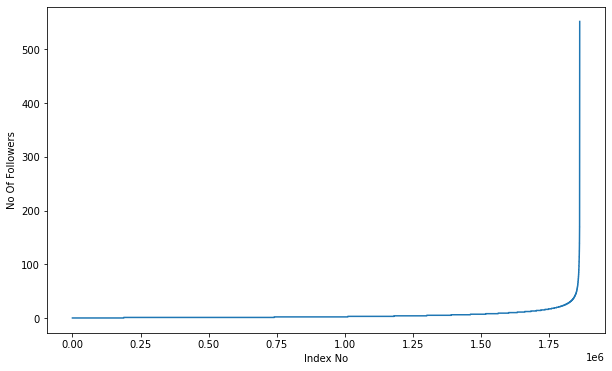

In [ ]:
import matplotlib.pyplot as plt

indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

<b>Number of people each person is following</b>

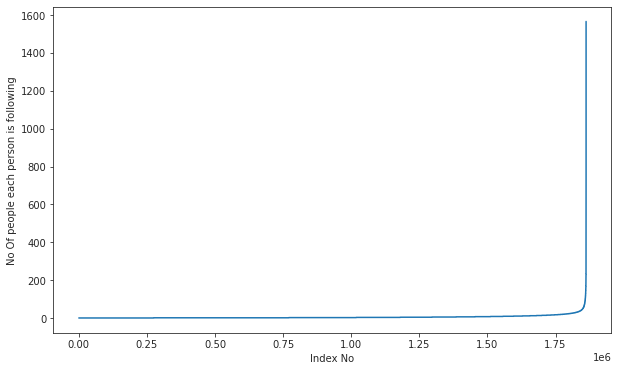

In [ ]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

In [ ]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is',
                                sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [ ]:
print('No of persons having zero followers are' ,sum(np.array(indegree_dist)==0),'and % is',
                                sum(np.array(indegree_dist)==0)*100/len(indegree_dist))

No of persons having zero followers are 188043 and % is 10.097786512871734


In [ ]:
count=0
for i in g.nodes():
    if len(list(g.predecessors(i)))==0 :
        if len(list(g.successors(i)))==0:
            count+=1
print('No of persons those are not not following anyone and also not having any followers are',count)

No of persons those are not not following anyone and also not having any followers are 0


<b>both followers + following of each person</b>

In [ ]:
from collections import Counter

dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

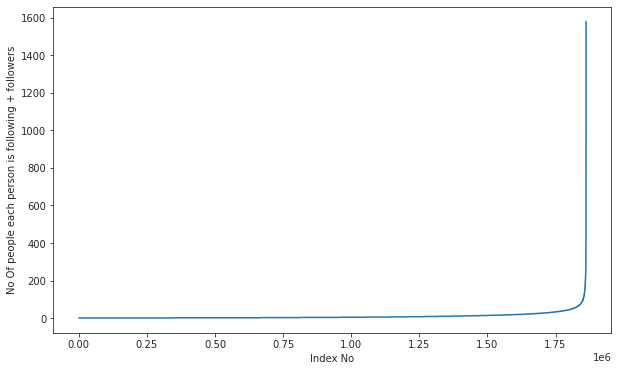

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following + followers')
plt.show()

In [ ]:
print('Min of no of followers + following is',in_out_degree.min())
print(np.sum(in_out_degree==in_out_degree.min()),' persons having minimum no of followers + following')

Min of no of followers + following is 1
334291  persons having minimum no of followers + following


In [ ]:
print('Max of no of followers + following is',in_out_degree.max())
print(np.sum(in_out_degree==in_out_degree.max()),' persons having maximum no of followers + following')

Max of no of followers + following is 1579
1  persons having maximum no of followers + following


In [ ]:
print('No of persons having followers + following less than 10 are',np.sum(in_out_degree<10))

No of persons having followers + following less than 10 are 1320326


#3.3 Xem dự đoán liên kết trên đồ thị như là 1 vấn đề phân lớp nhị phân

<b>Tạo 1 số cạnh không có trong đồ thị cho việc học giám sát</b>

Ở bước này, tác giả tiến hành tạo ra các liên kết giả không có trong đồ thị với tổng liên kết bằng với tổng số lượng liên kết thật mà có đường dẫn ngắn nhất lớn hơn 2 bằng các tạo ra ngẫu nhiên 2 nút trong khoảng từ 1 đến 1.862.220 vì đồ thị ban đầu có tổng cộng 1.862.220 nút, sau đó với các liên kết thật ở đồ thị gốc sẽ được gán là 1 còn với các liên kết giả được tạo ra sẽ được gán là -1 và cuối cùng là dùng thư viện pickle để lưu để lưu lại các liên kết giả này. 

In [ ]:
#from google.colab import drive

#drive.mount('/content/drive')

In [ ]:
#!unzip /content/drive/MyDrive/graph_mining_lab3.zip -d /content

In [ ]:
#cd /content/content

In [ ]:
import random
import csv
import pickle
import os

if not os.path.isfile('data/after_eda/missing_edges_final.p'):
    r = csv.reader(open('data/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1 
    missing_edges = set([])
    while (len(missing_edges) < 9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 
                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('data/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('data/after_eda/missing_edges_final.p','rb'))

In [ ]:
len(missing_edges)

9437519

<b>Phân chia các phần train, test từ dữ liệu</b>

Sau khi đã tạo được file pickle bao gồm danh sách các liên kết giả với số lượng liên kết bằng với số lượng các liên kết thật ban đầu, tác giả sử dụng 2 dataframe là df_pos để lưu danh sách các liên kết thật và df_neg để lưu danh sách các liên kết giả. Tiếp theo, với mỗi dataframe đã tạo, tác giả sử dụng hàm train_test_split() trong thư viện sklearn để tách tập dữ liệu ra với tỷ lệ train:test là 80:20 mà trong đó x_train_pos, x_test_pos, x_train_neg và x_test_neg là toàn bộ giá trị của 2 cột (nút nguồn và nút đích) trong dataframe ứng với các liên kết thật và các liên kết giả còn y_train_pos, y_test_pos, y_train_neg và t_test_neg sẽ là các giá trị đầu ra mô hình cần phải dự đoán mà được gán nhãn toán bộ là giá trị 1 nếu dataframe đó là dataframe của các liên kết thật và 0 ngược lại. Cuối cùng, với các giá trị train và test ở đầu vào sau khi đã tách ra cho cả dataframe chứa các liên kết thật và liên kết giả, tác giả tiến hành lưu vào 4 file csv khác nhau là train_pos_after_eda.csv, test_pos_after_eda.csv, train_neg_after_eda.csv và test_neg_after_eda.csv

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

if (not os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('data/after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('data/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('data/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('data/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

Number of nodes in the graph with edges 9437519
Number of nodes in the graph without edges 9437519
Number of nodes in the train data graph with edges 7550015 = 7550015
Number of nodes in the train data graph without edges 7550015 = 7550015
Number of nodes in the test data graph with edges 1887504 = 1887504
Number of nodes in the test data graph without edges 1887504 = 1887504


Ở bước này, tác giả dùng networkx và đọc 2 file train_pos_after_eda.csv và test_pos_after_eda.csv mà chứa các liên kết thật vào 2 đồ thị có hướng, sau đó lấy ra các nút không trùng nhau ở cả 2 đồ thị train và test và tiến hành 1 số khảo sát như in ra số lượng các nút xuất hiện đồng thời trong cả 2 đồ thị train và test, số lượng nút xuất hiện trong tập train nhưng không xuất hiện trong tập test, số lượng nút xuất hiện trọng tập test nhưng không xuất hiện trong tập train 

In [ ]:
import networkx as nx

if (os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and (os.path.isfile('data/after_eda/test_pos_after_eda.csv')):        
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    test_graph=nx.read_edgelist('data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
    print(nx.info(test_graph))

    # finding the unique nodes in the both train and test graphs
    train_nodes_pos = set(train_graph.nodes())
    test_nodes_pos = set(test_graph.nodes())

    trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
    trY_teN = len(train_nodes_pos - test_nodes_pos)
    teY_trN = len(test_nodes_pos - train_nodes_pos)

    print('no of people common in train and test -- ',trY_teY)
    print('no of people present in train but not present in test -- ',trY_teN)

    print('no of people present in test but not present in train -- ',teY_trN)
    print(' % of people not there in Train but exist in Test in total Test data are {} %'.format(teY_trN/len(test_nodes_pos)*100))

DiGraph with 1780722 nodes and 7550015 edges
DiGraph with 1144623 nodes and 1887504 edges
no of people common in train and test --  1063125
no of people present in train but not present in test --  717597
no of people present in test but not present in train --  81498
 % of people not there in Train but exist in Test in total Test data are 7.1200735962845405 %


Trong các hệ thống gợi ý sản phẩm thì có 1 vấn đề thường xảy ra đó là hệ thống đang dựa trên những dữ liệu từ hiện tại nên với những người dùng hiện tại nó xử lý tốt nhưng với những người mới vào hệ thống thì hệ thống có thể sẽ không hoạt động chính xác như chúng ta mong muốn mà vấn đề đó còn được gọi là cold start. Trong dự đoán liên kết thì vấn đề này cũng là một vấn đề phổ biến. Vì vậy sau khi đã đưa ra 1 số khảo sát ở trên, tác giả nhận thấy có vấn đề cold start xảy ra ở đây nên ở bước tiếp theo này, tác giả đầu tiên tiến hành đọc 2 tập dữ liệu train, test của các liên kết thật và 2 tập dữ liệu train, test của các liên kết giả, sau đó tác giả tiến hành tạo ra 4 file mới. Ở file train_after_eda.csv, nó chứa toàn bộ các liên kết từ cả 2 tập train của các liên kết giả và liên kết thật. Ở file train_y.csv, tác giả nối các kết quả đầu ra ở 2 file train chứa liên kết thật và liên kết giả lại với nhau. Một cách tương tự, file test_after_eda.csv chứa toàn bộ các liên kết từ cả 2 tập test của các liên kết thật và giả và ở file cuối cùng là test_y.csv, tác giả nối các kết quả đầu ra ở 2 file test chứa liên kết thật và liên kết giả lại với nhau

In [ ]:
#final train and test data sets
if (not os.path.isfile('data/after_eda/train_after_eda.csv')) and \
(not os.path.isfile('data/after_eda/test_after_eda.csv')) and \
(not os.path.isfile('data/train_y.csv')) and \
(not os.path.isfile('data/test_y.csv')) and \
(os.path.isfile('data/after_eda/train_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_pos_after_eda.csv')) and \
(os.path.isfile('data/after_eda/train_neg_after_eda.csv')) and \
(os.path.isfile('data/after_eda/test_neg_after_eda.csv')):
    
    X_train_pos = pd.read_csv('data/after_eda/train_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_pos = pd.read_csv('data/after_eda/test_pos_after_eda.csv', names=['source_node', 'destination_node'])
    X_train_neg = pd.read_csv('data/after_eda/train_neg_after_eda.csv', names=['source_node', 'destination_node'])
    X_test_neg = pd.read_csv('data/after_eda/test_neg_after_eda.csv', names=['source_node', 'destination_node'])

    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0])

    X_train = X_train_pos.append(X_train_neg,ignore_index=True)
    y_train = np.concatenate((y_train_pos,y_train_neg))
    X_test = X_test_pos.append(X_test_neg,ignore_index=True)
    y_test = np.concatenate((y_test_pos,y_test_neg)) 
    
    X_train.to_csv('data/after_eda/train_after_eda.csv',header=False,index=False)
    X_test.to_csv('data/after_eda/test_after_eda.csv',header=False,index=False)
    pd.DataFrame(y_train.astype(int)).to_csv('data/train_y.csv',header=False,index=False)
    pd.DataFrame(y_test.astype(int)).to_csv('data/test_y.csv',header=False,index=False)

Number of nodes in the train data graph with edges 7550015
Number of nodes in the train data graph without edges 7550015
Number of nodes in the test data graph with edges 1887504
Number of nodes in the test data graph without edges 1887504


In [ ]:
print("Data points in train data",X_train.shape)
print("Data points in test data",X_test.shape)
print("Shape of traget variable in train",y_train.shape)
print("Shape of traget variable in test", y_test.shape)

Data points in train data (15100030, 2)
Data points in test data (3775008, 2)
Shape of traget variable in train (15100030,)
Shape of traget variable in test (3775008,)


#3.4 Các độ đo tương đồng
Ở bước này, tác giả tiền hành đọc file train_pos_after_eda.csv mà chứa các liên kết thật trong tập train bằng networkx và tiến hành sử dụng 1 số độ đo tương đồng như jaccard và cosine cho 2 nút X và Y mà chia làm 2 trường hợp là tập các người ở trong nút X và Y đang theo dõi và tập các người mà nút X và Y được theo dõi. Về công thức tính của 2 độ đo này thì đã được nêu ở trong phần 2 của notebook

In [ ]:
if os.path.isfile('data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

DiGraph with 1780722 nodes and 7550015 edges


<b>Jaccard index</b>

In [ ]:
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

print(jaccard_for_followees(273084,1505602))
print(jaccard_for_followers(273084,1505602))

0.0
0


<b>Cosine similarity</b>

In [ ]:
import math

def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

def cosine_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

print(cosine_for_followees(273084,1505602))
print(cosine_for_followers(273084,1505602))

0.0
0


#3.5 Các độ đo xếp hạng

Ở đây thì tác giả sử dụng độ đo xếp hạng page rank để tính ra giá trị min, max và mean cho đồ thị train_graph mà chúng ta đã đọc từ file chứa các liên kết thật trong file train ở trên

In [ ]:
!mkdir /content/content/data/fea_sample

In [ ]:
import pickle

if not os.path.isfile('data/fea_sample/page_rank.p'):
    pr = nx.pagerank(train_graph, alpha=0.85)
    pickle.dump(pr,open('data/fea_sample/page_rank.p','wb'))
else:
    pr = pickle.load(open('data/fea_sample/page_rank.p','rb'))

print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

#for imputing to nodes which are not there in Train data
mean_pr = float(sum(pr.values())) / len(pr)
print(mean_pr)

min 1.6556497245737814e-07
max 2.709825134193587e-05
mean 5.615699699389075e-07
5.615699699389075e-07


#3.6 Một số đặc trưng khác

<b>Đường dẫn ngắn nhất</b>

Đặc trưng này là về đường dẫn ngắn nhất giữa 2 nút trong đồ thị mà đã loại bỏ đi các đường dẫn trực tiếp nếu có

In [ ]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

compute_shortest_path_length(77697, 826021)

10

<b>Kiểm tra cùng cộng đồng</b>

Đặc trưng này tác giả sẽ sử dụng hàm weakly_connected_components() có sẵn trong thư viện network để kiểm tra xem 2 nút có thuộc cùng cộng đồng hay không. Nếu có cạnh nối từ nút b đến a hoặc tồn tại cạnh nối từ nút a đến b sau khi đã loại bỏ cạnh nối trực tiếp thì xem như kết quả trả về 1 là 2 nút đó thuộc về cùng 1 cộng đồng cạnh kết nối và ngược lại là trả về 0 

In [ ]:
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

belongs_to_same_wcc(861, 1659750)

0

<b>Adamic/Adar Index</b>

Về đặc trưng chỉ số adamic/adar thì công thức của nó đã được chúng ta đề cập trong phần 2 của notebook

In [ ]:
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

calc_adar_in(1,189226)

0

<b>Nút nguồn có được theo dõi lại bởi nút đích hay không</b>

Đặc trưng này sẽ trả về kết quả là 1 nếu tồn tại cạnh nối từ nút b đến a và ngược lại kết quả là 0

In [ ]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

follows_back(1,189226)

1

<b>Katz Centrality</b>

Về đặc trưng độ trung tâm Katz cũng đã được chúng ta trình bày ở phần 2 notebook, ở đây tác giả cũng lấy ra các giá trị min, max và mean giống như thuật toán page rank ở trên

In [ ]:
if not os.path.isfile('data/fea_sample/katz.p'):
    katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
    pickle.dump(katz,open('data/fea_sample/katz.p','wb'))
else:
    katz = pickle.load(open('data/fea_sample/katz.p','rb'))

print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

min 0.0007313532503674038
max 0.003394554990800175
mean 0.0007483800934937644
0.0007483800934937644


<b>Hits Score</b>

Đặc trưng điểm hits cũng được chúng ta trình bày ở phần 2 notebook và tác giả cũng lấy ra các giá trị min, max và mean giống như thuật toán page rank và độ trung tâm Katz ở trên

In [ ]:
if not os.path.isfile('data/fea_sample/hits.p'):
    hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    pickle.dump(hits,open('data/fea_sample/hits.p','wb'))
else:
    hits = pickle.load(open('data/fea_sample/hits.p','rb'))

print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

min -5.987760234286354e-21
max 0.004868653379538979
mean 5.615699699308676e-07


#3.7 Thêm các độ đo tương đồng, độ đo xếp hạng và các đặc trưng vào dataframe

<b>Đọc 1 phần dữ liệu từ tập train và test</b>

Ở bước này, do tác giả đã gộp các đầu vào và ra của các liên kết thật và giả lại với nhau nên các file được tạo ra có kích thước tương đối lớn mà có thể dẫn đến không đủ bộ nhớ cho việc đọc file, vì vậy tác giả xử lý bằng cách chỉ đọc ngẫu nhiên 1 lượng nhỏ các hàng trong 2 file train_after_eda.csv mà chứa các liên kết thật và các liên kết giả của phần train và test_after_eda.csv mà chứa các liên kết thật và các liên kết giả của phần test và bỏ qua 1 số lượng lớn các hàng còn lại

In [ ]:
import random

if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/train_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 15100030
    # n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_train =  15100028
    s = 100000 #desired sample size
    skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))
    #https://stackoverflow.com/a/22259008/4084039

if os.path.isfile('data/after_eda/train_after_eda.csv'):
    filename = "data/after_eda/test_after_eda.csv"
    # you uncomment this line, if you dont know the lentgh of the file name
    # here we have hardcoded the number of lines as 3775008
    # n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
    n_test = 3775006
    s = 50000 #desired sample size
    skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))
    #https://stackoverflow.com/a/22259008/4084039

print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

Number of rows in the train data file: 15100028
Number of rows we are going to elimiate in train data are 15000028
Number of rows in the test data file: 3775006
Number of rows we are going to elimiate in test data are 3725006


Tiếp theo, sau khi đã có được danh sách các hàng sẽ bỏ qua trong lúc đọc file, tác giả tiến hành đọc 2 file train_after_eda.csv và test_after_eda.csv vào 2 dataframe là df_final_train và df_final_test. Ngoài ra, tác giả cũng tạo thêm 1 cột indicator_link cho 2 dataframe này bằng cách đọc từ 2 file train_y.csv và test_y.csv mà hàng đó có giá trị 1 nếu là liên kết thật và 0 nếu là liên kết giả 

In [ ]:
import pandas as pd

df_final_train = pd.read_csv('data/after_eda/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

df_final_test = pd.read_csv('data/after_eda/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

Our train matrix size  (100002, 3)
Our test matrix size  (50002, 3)


,source_node,destination_node,indicator_link
0,848424,784690,1
1,1256533,820931,1


<b>Thêm các đặc trưng vào dataframe</b>

Ở phần này, tác giả tiến hành thêm 10 đặc trưng dưới đây cho các điểm dữ liệu trong cả 2 dataframe df_final_train và df_final_test ở trên
<ol>
<li>jaccard_followers</li>
<li>jaccard_followees</li>
<li>cosine_followers</li>
<li>cosine_followees</li>
<li>num_followers_s</li>
<li>num_followees_s</li>
<li>num_followers_d</li>
<li>num_followees_d</li>
<li>inter_followers</li>
<li>inter_followees</li>
</ol>

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    #mapping jaccrd followers to train and test data
    df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
    #mapping jaccrd followees to train and test data
    df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
    #mapping cosine followers to train and test data
    df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
    #mapping cosine followees to train and test data
    df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
    df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'],row['destination_node']),axis=1)

Về đặc trưng num_followers_s và num_followees_s thì nó là tổng số lượng người theo dõi và được theo dõi của nút nguồn còn inter_followers và inter_followees là phần giao của tổng số lượng người theo dõi của nút nguồn với nút đích và phần giao tổng số lượng người được theo dõi của nút nguồn với nút đích

In [ ]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

Sau khi đã thêm toàn bộ 10 đặc trưng trên vào 2 dataframe df_final_train và df_final_test, tác giả tiến hành lưu vào file storage_sample_stage1.h5 và đọc lại file .h5 vừa lưu này vào 2 dataframe df_final_train và df_final_test mới

In [ ]:
from pandas import HDFStore
from pandas import read_hdf

if not os.path.isfile('data/fea_sample/storage_sample_stage1.h5'):
    df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
    df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
    df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)
    
    df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
    df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
    df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)
    
    hdf = HDFStore('data/fea_sample/storage_sample_stage1.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage1.h5', 'test_df',mode='r')

Ngoài các đặc trưng đã thêm ở trên, sẽ có 4 đặc trưng khác sẽ được tác giả thêm vào tiếp cho cả 2 dataframe df_final_train và df_final_test
<ol>
<li>adar index</li>
<li>is following back</li>
<li>belongs to same weakly connect components</li>
<li>shortest path between source and destination</li>
</ol>

Sau khi đã thêm các đặc trưng này vào 2 dataframe trên, tác giả lưu lại vào storage_sample_stage2.h5 và tiến hành đọc file .h5 này lên và tiếp tục sử dụng 2 dataframe df_final_train và df_final_test trên file .h5 mới này

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage2.h5'):
    #mapping adar index on train
    df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
    #mapping adar index on test
    df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping followback or not on train
    df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #mapping followback or not on test
    df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

    #--------------------------------------------------------------------------------------------------------
    #mapping same component of wcc or not on train
    df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

    ##mapping same component of wcc or not on train
    df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
    
    #--------------------------------------------------------------------------------------------------------
    #mapping shortest path on train 
    df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
    #mapping shortest path on test
    df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

    hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage2.h5', 'test_df',mode='r')

Sau khi đã thêm tổng cộng 14 đặc trưng ở trên, chúng ta vẫn còn tiếp 9 đặc trưng nữa cần thêm như dưới đây
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>katz of source</li>
<li>katz of dest</li>
<li>hubs of source</li>
<li>hubs of dest</li>
<li>authorities_s of source</li>
<li>authorities_s of dest</li>
</ol>
Về cánh tính đặc trưng trọng số cho các nút thì chúng ta cũng đã chỉ ra ở phần 2 của notebook

In [ ]:
from tqdm import tqdm
import numpy as np

#weight for source and destination of each link
Weight_in = {}
Weight_out = {}
for i in tqdm(train_graph.nodes()):
    s1=set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1+len(s1)))
    Weight_in[i]=w_in
    
    s2=set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1+len(s2)))
    Weight_out[i]=w_out
    
#for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780722/1780722 [00:22<00:00, 80641.24it/s] 


In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    #mapping to pandas train
    df_final_train['weight_in'] = df_final_train.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_train['weight_out'] = df_final_train.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))

    #mapping to pandas test
    df_final_test['weight_in'] = df_final_test.destination_node.apply(lambda x: Weight_in.get(x,mean_weight_in))
    df_final_test['weight_out'] = df_final_test.source_node.apply(lambda x: Weight_out.get(x,mean_weight_out))


    #some features engineerings on the in and out weights
    df_final_train['weight_f1'] = df_final_train.weight_in + df_final_train.weight_out
    df_final_train['weight_f2'] = df_final_train.weight_in * df_final_train.weight_out
    df_final_train['weight_f3'] = (2*df_final_train.weight_in + 1*df_final_train.weight_out)
    df_final_train['weight_f4'] = (1*df_final_train.weight_in + 2*df_final_train.weight_out)

    #some features engineerings on the in and out weights
    df_final_test['weight_f1'] = df_final_test.weight_in + df_final_test.weight_out
    df_final_test['weight_f2'] = df_final_test.weight_in * df_final_test.weight_out
    df_final_test['weight_f3'] = (2*df_final_test.weight_in + 1*df_final_test.weight_out)
    df_final_test['weight_f4'] = (1*df_final_test.weight_in + 2*df_final_test.weight_out)

In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage3.h5'):
    #page rank for source and destination in Train and Test
    #if anything not there in train graph then adding mean page rank 
    df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

    df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
    df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
    #================================================================================

    #Katz centrality score for source and destination in Train and test
    #if anything not there in train graph then adding mean katz score
    df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

    df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
    df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
    #================================================================================

    #Hits algorithm score for source and destination in Train and test
    #if anything not there in train graph then adding 0
    df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

    df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
    df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
    #================================================================================

    #Hits algorithm score for source and destination in Train and Test
    #if anything not there in train graph then adding 0
    df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

    df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
    df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
    #================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
    df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

Đặc trưng cuối cùng mà tác giả sẽ thêm là các đặc trưng SVD trong sẵn trong thư viện scipy mà trong đó số lượng các giá trị singular và các vector singular vectors k cần phải tính là 6. Sau khi đã thêm các đặc trưng SVD vào dataframe, tác giả cũng lưu lại vào file storage_sample_stage4.h4 và tiến hành đọc file này lên và tiếp tục sử dụng 2 dataframe df_final_train và df_final_test trên file .h5 mới này

In [ ]:
from scipy.sparse.linalg import svds, eigs

def svd(x, S):
    try:
        z = sadj_dict[x]
        return S[z]
    except:
        return [0,0,0,0,0,0]

#for svd features to get feature vector creating a dict node val and inedx in svd vector
sadj_col = sorted(train_graph.nodes())
sadj_dict = { val:idx for idx,val in enumerate(sadj_col)}

Adj = nx.adjacency_matrix(train_graph,nodelist=sorted(train_graph.nodes())).asfptype()

U, s, V = svds(Adj, k = 6)
print('Adjacency matrix Shape',Adj.shape)
print('U Shape',U.shape)
print('V Shape',V.shape)
print('s Shape',s.shape)

Adjacency matrix Shape (1780722, 1780722)
U Shape (1780722, 6)
V Shape (6, 1780722)
s Shape (6,)


In [ ]:
if not os.path.isfile('data/fea_sample/storage_sample_stage4.h5'):
    #===================================================================================================
    df_final_train[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_train.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_train[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    #===================================================================================================
    
    df_final_train[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_train.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_train[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_train.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================
    
    df_final_test[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']] = \
    df_final_test.source_node.apply(lambda x: svd(x, U)).apply(pd.Series)
    
    df_final_test[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, U)).apply(pd.Series)

    #===================================================================================================
    
    df_final_test[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6',]] = \
    df_final_test.source_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)

    df_final_test[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']] = \
    df_final_test.destination_node.apply(lambda x: svd(x, V.T)).apply(pd.Series)
    #===================================================================================================

    hdf = HDFStore('data/fea_sample/storage_sample_stage4.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()

#3.8 Dự đoán liên kết với mô hình Random Forest
Ở phần này tác giả chọn đầu ra cần dự đoán của mô hình là cột indicator_link mà có nhãn là 1 nếu là liên kết thật và 0 nếu là liên kết giả và loại bỏ các cột nút nguồn, nút đích và indicator_link trong 2 dataframe df_final_train, df_final_test và sử dụng các đặc trưng còn lại đã được thêm vào trước đó cho việc học của mô hình

In [ ]:
from pandas import read_hdf

df_final_train = read_hdf('/content/content/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/content/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [ ]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Do có 1 vài siêu tham số trong mô hình Random Forest của thư viện sklearn ở phiên bản mới nhất đã bị loại bỏ nên nếu muốn chạy cùng các siêu tham số như tác giả chúng ta cần sử dụng sklearn ở phiên bản 0.23.2

In [ ]:
!pip install scikit-learn==0.23.2

Tác giả thực hiện việc huấn luyện mô hình theo 2 siêu tham số cần dò là theo estimators và theo depths thì nhìn chung nếu chạy mô hình dò siêu tham số theo depths sẽ có kết quả độ đo F score trên cả tập train và test tốt hơn

Estimators =  10 Train Score 0.9214118038099591 test Score 0.914811940173271
Estimators =  50 Train Score 0.9253917972657553 test Score 0.9200791212491056
Estimators =  100 Train Score 0.9247973628482907 test Score 0.9185166445301794
Estimators =  250 Train Score 0.9236037879657956 test Score 0.9160750507099391
Estimators =  450 Train Score 0.9245633826355812 test Score 0.9176614760506244


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

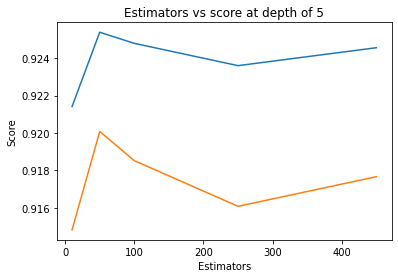

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8850644459323735 test Score 0.8524710876250704
depth =  9 Train Score 0.9588856985765777 test Score 0.9237148297017136
depth =  11 Train Score 0.9620068044482811 test Score 0.9254172829072471
depth =  15 Train Score 0.9648673023722424 test Score 0.9199864095812452
depth =  20 Train Score 0.9656052245228574 test Score 0.9271338762077549
depth =  35 Train Score 0.9655444742570749 test Score 0.9270670662220909
depth =  50 Train Score 0.9655444742570749 test Score 0.9270670662220909
depth =  70 Train Score 0.9655444742570749 test Score 0.9270670662220909
depth =  130 Train Score 0.9655444742570749 test Score 0.9270670662220909


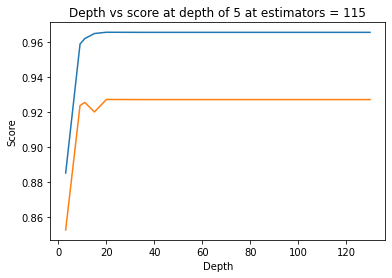

In [ ]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

Ở bước này thì tác giả sử dụng hàm RandomizedSearchCV() trong thư viện sklearn để tìm ra các bộ siêu tham số tốt nhất thì kết quả cuối cùng theo độ đo F score cho cả tập train và test nhìn chung không thay đổi so với kết quả chạy ở trên

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25, return_train_score=True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96336808 0.96318359 0.96107172 0.96287358 0.96486406]
mean train scores [0.96390706 0.96357596 0.96161725 0.96348722 0.965691  ]


In [ ]:
print(rf_random.best_estimator_)

RandomForestClassifier(max_depth=14, min_samples_leaf=28, min_samples_split=111,
                       n_estimators=121, n_jobs=-1, random_state=25)


In [ ]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.966052101367838
Test f1 score 0.9267499788904838


Bước này tác giả tiến hành trực quan hóa ra các ma trận confusion, Recall và Precision của mô hình trên

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


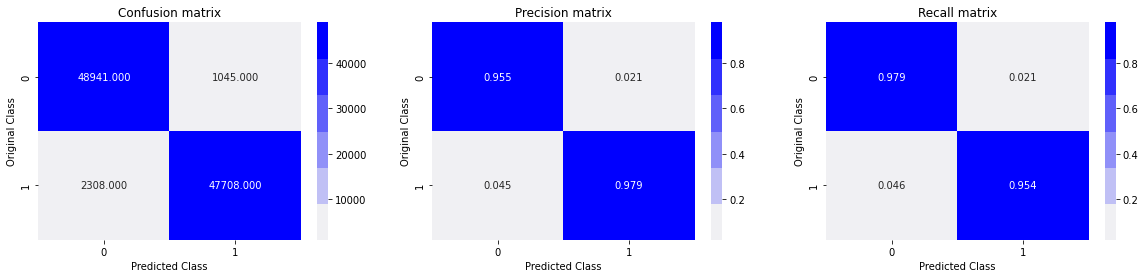

Test confusion_matrix


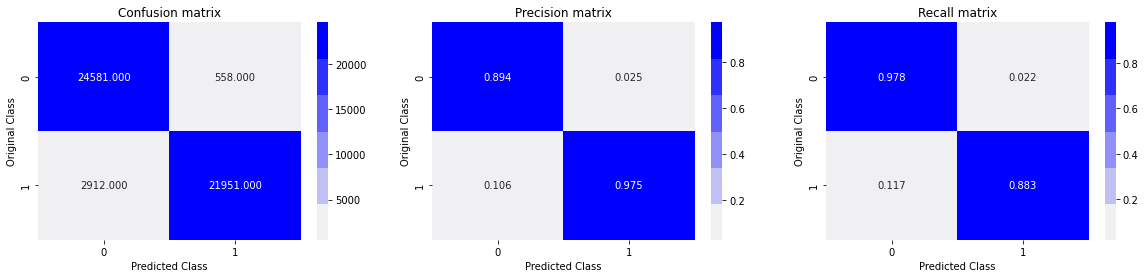

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

Để đánh giá hiệu suất của mô hình, bên cạnh confusion matrix tác giả cũng sử dụng 1 phương pháp phổ biến khác là AUC-ROC

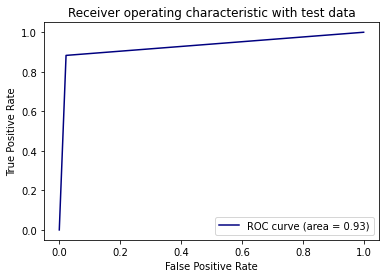

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

Dưới đây là phần trực quan xếp hạng các đặc trưng quan trọng nhất mà mô hình đã sử dụng cho việc học để dự đoán

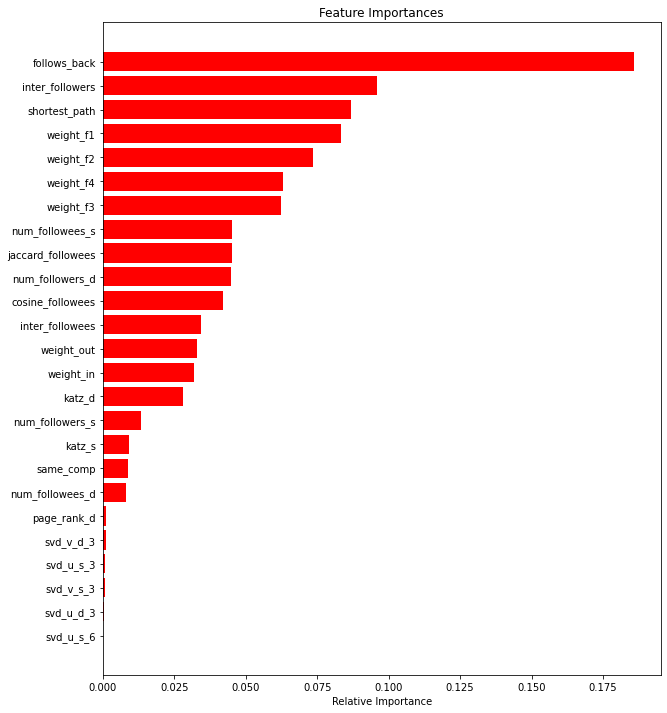

In [ ]:
import numpy as np

features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#3.9 Phần mở rộng
Ở phần mở rộng này, tác giả sẽ tiến hành đọc 2 file train_pos_after_eda.csv và test_pos_after_eda.csv mà chứa các liên kết thật của cả phần train và phần test vào 2 đồ thị train_graph và test_graph

In [ ]:
import networkx as nx

train_graph=nx.read_edgelist('/content/content/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
test_graph=nx.read_edgelist('/content/content/data/after_eda/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)

Kế tiếp tác giả sẽ chỉnh lại 1 chút ở hàm compute_features_stage() ở trên mà bao gồm tổng số lượng người theo dõi và được theo dõi của nút nguồn và đích cũng như phần giao của chúng nhưng thay vì sử dụng cho đồ thị train_graph như hàm ở phía trên, tác giả chỉnh sửa lại 1 chút thành hàm compute_features_stage() đề nó có thể sử dụng cho các đồ thị chung khác

In [ ]:
from tqdm import tqdm

def compute_features_stage1(df,graph):
  num_followers_s =[]
  num_followees_s =[]
  num_followers_d =[]
  num_followees_d = []
  inter_followers= []
  inter_followees =[]
  for i,row in tqdm(df.iterrows()):
    try:
      s1 = set(graph.predecessors(row['source_node']))
      s2 = set(graph.successors(row['source_node']))
    except:
      s1 = set()
      s2 = set()
    try: 
      d1 = set(graph.predecessors(row["destination_node"]))
      d2 = set(graph.successors(row['destination_node']))
    except:
      d1 = set()
      d2 = set()
    num_followers_s.append(len(s1))
    num_followees_s.append(len(s2))
    num_followers_d.append(len(d1))
    num_followees_d.append(len(d2))

    inter_followees.append(len(s1.intersection(d1)))
    inter_followers.append(len(s2.intersection(d2)))

  return num_followers_d,num_followees_d,num_followers_s,num_followees_s,inter_followers,inter_followees       

In [ ]:
train_num_followers_d,train_num_followees_d,train_num_followers_s,train_num_followees_s,train_inter_followers,train_inter_followees = compute_features_stage1(df_final_train,train_graph)
test_num_followers_d,test_num_followees_d,test_num_followers_s,test_num_followees_s,test_inter_followers,test_inter_followees = compute_features_stage1(df_final_test,test_graph)

100002it [00:10, 9270.04it/s]
50002it [00:02, 17142.85it/s]


In [ ]:
df_final_train["num_followers_d"] = train_num_followers_d
df_final_train.head()

In [ ]:
df_final_test['num_followers_d'] = test_num_followees_d
df_final_test.head()

Ở đây, tác giả có thêm 4 cột đặc trưng mới cho cả 2 dataframe df_final_train và df_final_test là followers_preferential_attch mà là các kết quả tổng số người theo dõi của nút nguồn nhân với tổng số người theo dõi của nút đích và followees_preferential_attach mà là các kết quả tổng số người được theo dõi của nút nguồn nhân với tổng số người được theo dõi của nút đích

In [ ]:
source = np.array(df_final_train["num_followers_s"])
destination = np.array(df_final_train["num_followers_d"])
followers_preferential = []
for i in range(len(source)):
  followers_preferential.append(source[i]*destination[i])
df_final_train["followers_preferential_attach"]  = followers_preferential 
df_final_train.head()

In [ ]:
source = np.array(df_final_train["num_followees_s"])
destination = np.array(df_final_train["num_followees_s"])
followees_preferential = []
for i in range(len(source)):
  followees_preferential.append(source[i]*destination[i])
df_final_train["followees_preferential_attach"]  = followees_preferential 
df_final_train.head()

In [ ]:
source = np.array(df_final_test["num_followers_s"])
destination = np.array(df_final_test["num_followers_d"])
followers_preferential = []
for i in range(len(source)):
  followers_preferential.append(source[i]*destination[i])
df_final_test["followers_preferential_attach"]  = followers_preferential 
df_final_test.head()

In [ ]:
source = np.array(df_final_test["num_followees_s"])
destination = np.array(df_final_test["num_followees_s"])
followees_preferential = []
for i in range(len(source)):
  followees_preferential.append(source[i]*destination[i])
df_final_test["followees_preferential_attach"]  = followees_preferential 
df_final_test.head()

In [ ]:
sorted(df_final_train.columns)

Về các đặc trưng SVD thì tác giả sử dụng 1 số đặc trưng mới cho cả 2 dataframe df_final_train và df_final_test như tích vô hướng của ma trận đơn nhất có các vector singular bên trái ở dạng cột u giữa nút nguồn và nút đích, tích vô hướng của ma trận đơn nhất có các vector singular bên phải ở dạng hàng v giữa nút nguồn và nút đích

In [ ]:
svd_dot_U =[]
range_value = len(np.array(df_final_train["svd_u_d_1"]))
for i in range(range_value):
  u_s = []
  u_d = []
  u_s.append(np.array(df_final_train["svd_u_s_1"][i]))
  u_s.append(np.array(df_final_train["svd_u_s_2"][i]))
  u_s.append(np.array(df_final_train["svd_u_s_3"][i]))
  u_s.append(np.array(df_final_train["svd_u_s_4"][i]))
  u_s.append(np.array(df_final_train["svd_u_s_5"][i]))
  u_s.append(np.array(df_final_train["svd_u_s_6"][i]))

  u_d.append(np.array(df_final_train["svd_u_d_1"][i]))
  u_d.append(np.array(df_final_train["svd_u_d_2"][i]))
  u_d.append(np.array(df_final_train["svd_u_d_3"][i]))
  u_d.append(np.array(df_final_train["svd_u_d_4"][i]))
  u_d.append(np.array(df_final_train["svd_u_d_5"][i]))
  u_d.append(np.array(df_final_train["svd_u_d_6"][i]))

  svd_dot_U.append(np.dot(u_s,u_d))

In [ ]:
df_final_train["svd_dot_U"] = svd_dot_U
df_final_train.head()

In [ ]:
svd_dot_V = []
range_value = len(np.array(df_final_train["svd_v_d_1"]))
for i in range(range_value):
  v_s = []
  v_d = []
  v_s.append(np.array(df_final_train["svd_v_s_1"][i]))
  v_s.append(np.array(df_final_train["svd_v_s_2"][i]))
  v_s.append(np.array(df_final_train["svd_v_s_3"][i]))
  v_s.append(np.array(df_final_train["svd_v_s_4"][i]))
  v_s.append(np.array(df_final_train["svd_v_s_5"][i]))
  v_s.append(np.array(df_final_train["svd_v_s_6"][i]))

  v_d.append(np.array(df_final_train["svd_v_d_1"][i]))
  v_d.append(np.array(df_final_train["svd_v_d_2"][i]))
  v_d.append(np.array(df_final_train["svd_v_d_3"][i]))
  v_d.append(np.array(df_final_train["svd_v_d_4"][i]))
  v_d.append(np.array(df_final_train["svd_v_d_5"][i]))
  v_d.append(np.array(df_final_train["svd_v_d_6"][i]))

  svd_dot_V.append(np.dot(v_s,v_d))

In [ ]:
df_final_train["svd_dot_V"] = svd_dot_V
df_final_train.head()

In [ ]:
svd_dot_U =[]
range_value = len(np.array(df_final_test["svd_u_d_1"]))
for i in range(range_value):
  u_s = []
  u_d = []
  u_s.append(np.array(df_final_test["svd_u_s_1"][i]))
  u_s.append(np.array(df_final_test["svd_u_s_2"][i]))
  u_s.append(np.array(df_final_test["svd_u_s_3"][i]))
  u_s.append(np.array(df_final_test["svd_u_s_4"][i]))
  u_s.append(np.array(df_final_test["svd_u_s_5"][i]))
  u_s.append(np.array(df_final_test["svd_u_s_6"][i]))

  u_d.append(np.array(df_final_test["svd_u_d_1"][i]))
  u_d.append(np.array(df_final_test["svd_u_d_2"][i]))
  u_d.append(np.array(df_final_test["svd_u_d_3"][i]))
  u_d.append(np.array(df_final_test["svd_u_d_4"][i]))
  u_d.append(np.array(df_final_test["svd_u_d_5"][i]))
  u_d.append(np.array(df_final_test["svd_u_d_6"][i]))

  svd_dot_U.append(np.dot(u_s,u_d))

In [ ]:
df_final_test["svd_dot_U"] = svd_dot_U
df_final_test.head()

In [ ]:
svd_dot_V = []
range_value = len(np.array(df_final_test["svd_v_d_1"]))
for i in range(range_value):
  v_s = []
  v_d = []
  v_s.append(np.array(df_final_test["svd_v_s_1"][i]))
  v_s.append(np.array(df_final_test["svd_v_s_2"][i]))
  v_s.append(np.array(df_final_test["svd_v_s_3"][i]))
  v_s.append(np.array(df_final_test["svd_v_s_4"][i]))
  v_s.append(np.array(df_final_test["svd_v_s_5"][i]))
  v_s.append(np.array(df_final_test["svd_v_s_6"][i]))

  v_d.append(np.array(df_final_test["svd_v_d_1"][i]))
  v_d.append(np.array(df_final_test["svd_v_d_2"][i]))
  v_d.append(np.array(df_final_test["svd_v_d_3"][i]))
  v_d.append(np.array(df_final_test["svd_v_d_4"][i]))
  v_d.append(np.array(df_final_test["svd_v_d_5"][i]))
  v_d.append(np.array(df_final_test["svd_v_d_6"][i]))

  svd_dot_V.append(np.dot(v_s,v_d))

In [ ]:
df_final_test["svd_dot_V"] = svd_dot_V
df_final_test.head()

In [ ]:
x_train  =  df_final_train
x_test = df_final_test

In [ ]:
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    labels = [0,1]
    cmap=sns.light_palette("green")
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(5,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(5,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))

    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(5,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Thay vì sử dụng mô hình Random Forest như ban đầu, tác giả sẽ sử dụng mô hình xgboost với hàm RandomizedSearchCV() để dò tìm ra các siêu tham số tốt nhất

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
        'n_estimators' :[100,200,500,1000,2000],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
          }
xgboost = XGBClassifier()          
random_cfl1=RandomizedSearchCV(xgboost,param_distributions = params,verbose=10,n_jobs=-1)
random_cfl1.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 41.8min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 48.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 77.5min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 115.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 122.9min finished


RandomizedSearchCV(estimator=XGBClassifier(), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         2000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   verbose=10)

In [ ]:
print(random_cfl1.best_params_)

{'subsample': 1.0, 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 2, 'colsample_bytree': 0.6}


Ở đây chúng ta sẽ sử dụng các siêu tham số tốt nhất theo như code của tác giả chứ không phải là các siêu tham số mà chúng ta chạy ra được ở trên vì kết quả phiên bản sklearn là khác nhau sẽ cho ra các siêu tham số tốt nhất khác nhau

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

best_xgb = XGBClassifier(sub_sample=0.8,learning_rate = 0.2,colsample_bytree=0.6,max_depth=5,n_estimators=1000,min_child_weight=5,gamma=5)
best_xgb.fit(x_train,y_train)
clf = CalibratedClassifierCV(best_xgb,method="sigmoid")
clf.fit(x_train,y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(colsample_bytree=0.6,
                                                    gamma=5, learning_rate=0.2,
                                                    max_depth=5,
                                                    min_child_weight=5,
                                                    n_estimators=1000,
                                                    sub_sample=0.8))

the train log loss is 0.025010457019960495
the test log loss is 0.33270177141528057
Number of misclassified points  8.461661533538658
-------------------------------------------------- Confusion matrix --------------------------------------------------


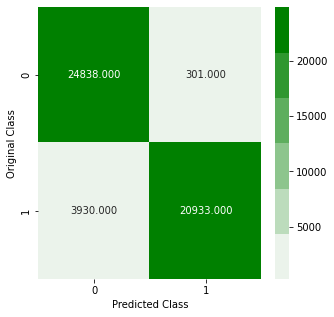

-------------------------------------------------- Precision matrix --------------------------------------------------


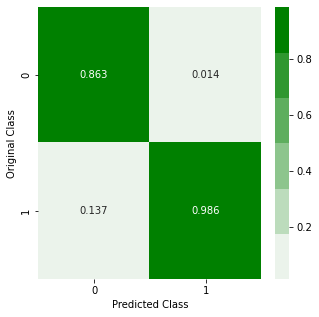

Sum of columns in precision matrix [1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


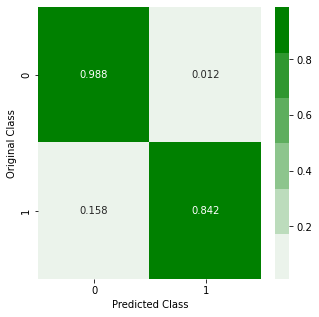

Sum of rows in precision matrix [1. 1.]


In [ ]:
from sklearn.metrics import log_loss

predict_y = clf.predict_proba(x_train)
print("the train log loss is",log_loss(y_train,predict_y,labels=best_xgb.classes_))
predict_y = clf.predict_proba(x_test)
print("the test log loss is",log_loss(y_test,predict_y,labels = best_xgb.classes_))
plot_confusion_matrix(y_test,clf.predict(x_test))

Nhìn chung kết quả của mô hình theo độ độ F score thì trên tập train tốt hơn nhiều so với mô hình Random Forest trước đó nhưng kết quả trên tập test lại tệ hơn nhiều mà có thể do dữ liệu này sẽ phù hợp với mô hình Random Forest hơn hoặc do có vấn đề overfitting diễn ra ở đây

In [ ]:
from sklearn.metrics import f1_score

print("f1 score for train data",f1_score(y_train,clf.predict(x_train)))
print("f1 score for test data",f1_score(y_test,clf.predict(x_test)))

f1 score for train data 0.9916148228293211
f1 score for test data 0.9082152851595549


Về độ đo hiệu suất AUC-ROC thì mô hình xgboost có kết quả đạt được là 0.915 mà có phần kém hơn so với mô hình Random Forest đạt được là 0.93

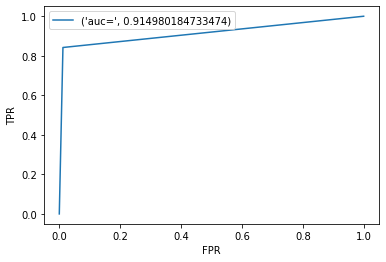

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr,tpr,ths = roc_curve(y_test,clf.predict(x_test))
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr,label = ('auc=',auc_sc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

Dưới đây là danh sách xếp hạng các đặc trưng quan trọng nhất mà mô hình sử dụng học để dự đoán từ dataframe với các đặc trưng mới đã được thêm vào

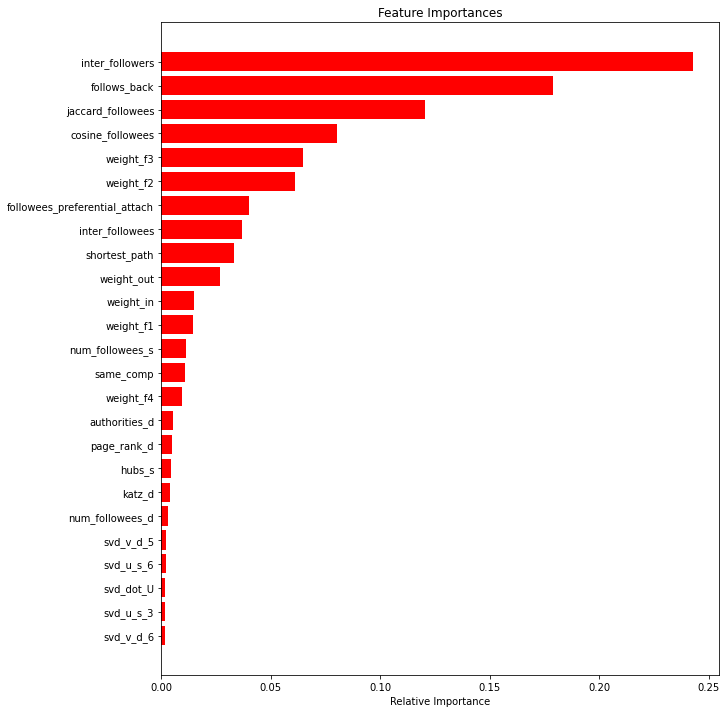

In [ ]:
features = df_final_train.columns
importances = best_xgb.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Dưới đây là bảng kết quả cuối chạy trên mô hình xgboost theo độ đo F score của tác giả thì có 1 chút sự chênh lệch so với kết quả chạy ra ở trên vì do khác phiên bản sklearn sử dụng nhưng nó vẫn có kết quả trên tập test kém hơn so với khi sử dụng mô hình Random Forest ở ban đầu

In [ ]:
from prettytable import PrettyTable

t = PrettyTable()
t.field_names=["model","train_f1_Score","test_f1_score"]
t.add_row(["XGBoost","0.9920553921274338","0.9124241511382708"])
print(t)

+---------+--------------------+--------------------+
|  model  |   train_f1_Score   |   test_f1_score    |
+---------+--------------------+--------------------+
| XGBoost | 0.9920553921274338 | 0.9124241511382708 |
+---------+--------------------+--------------------+


#4. Link tham khảo

[1] genialgokul1099. (2020, October 19). Social network graph link prediction. Kaggle. Retrieved February 17, 2022, from https://www.kaggle.com/genialgokul1099/social-network-graph-link-prediction/notebook.

[2] Easiest way to download kaggle data in Google Colab: Data Science and Machine Learning. Kaggle. (n.d.). Retrieved February 17, 2022, from https://www.kaggle.com/general/74235.

[3] YouTube. (2017, May 22). PageRank algorithm - example. YouTube. Retrieved February 17, 2022, from https://www.youtube.com/watch?v=P8Kt6Abq_rM.